# Get Data From Drive

In [1]:
!gdown "19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t"
!gdown "1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t
To: /content/Dataset.zip
100% 845M/845M [00:09<00:00, 88.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t
To: /content/Patterns.zip
100% 271M/271M [00:02<00:00, 122MB/s] 


In [2]:
!unzip /content/Dataset.zip -d Dataset
!unzip /content/Patterns.zip -d Patterns

Archive:  /content/Dataset.zip
 extracting: Dataset/1644359422.816138.jpg  
  inflating: Dataset/1644359422.816138.json  
 extracting: Dataset/1644360063.82364.jpg  
  inflating: Dataset/1644360063.82364.json  
 extracting: Dataset/1644362482.7094185.jpg  
  inflating: Dataset/1644362482.7094185.json  
 extracting: Dataset/1644368971.6154966.jpg  
  inflating: Dataset/1644368971.6154966.json  
 extracting: Dataset/1644369207.922902.jpg  
  inflating: Dataset/1644369207.922902.json  
 extracting: Dataset/1644369658.7214494.jpg  
  inflating: Dataset/1644369658.7214494.json  
 extracting: Dataset/1644369774.9055796.jpg  
  inflating: Dataset/1644369774.9055796.json  
 extracting: Dataset/1644369801.9909956.jpg  
  inflating: Dataset/1644369801.9909956.json  
 extracting: Dataset/1644369842.0238864.jpg  
  inflating: Dataset/1644369842.0238864.json  
 extracting: Dataset/1644369905.2248352.jpg  
  inflating: Dataset/1644369905.2248352.json  
 extracting: Dataset/1644369972.1056488.jpg  
 

# Read image and pattern

In [11]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import json
from google.colab.patches import cv2_imshow
from skimage import exposure
from skimage.exposure import match_histograms
from skimage import data
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
import random
import keras.backend as K
from keras.utils.vis_utils import plot_model

In [4]:
img_name = "/content/Dataset/1644362482.7094185.jpg"
json_name = img_name[:-3] + "json"

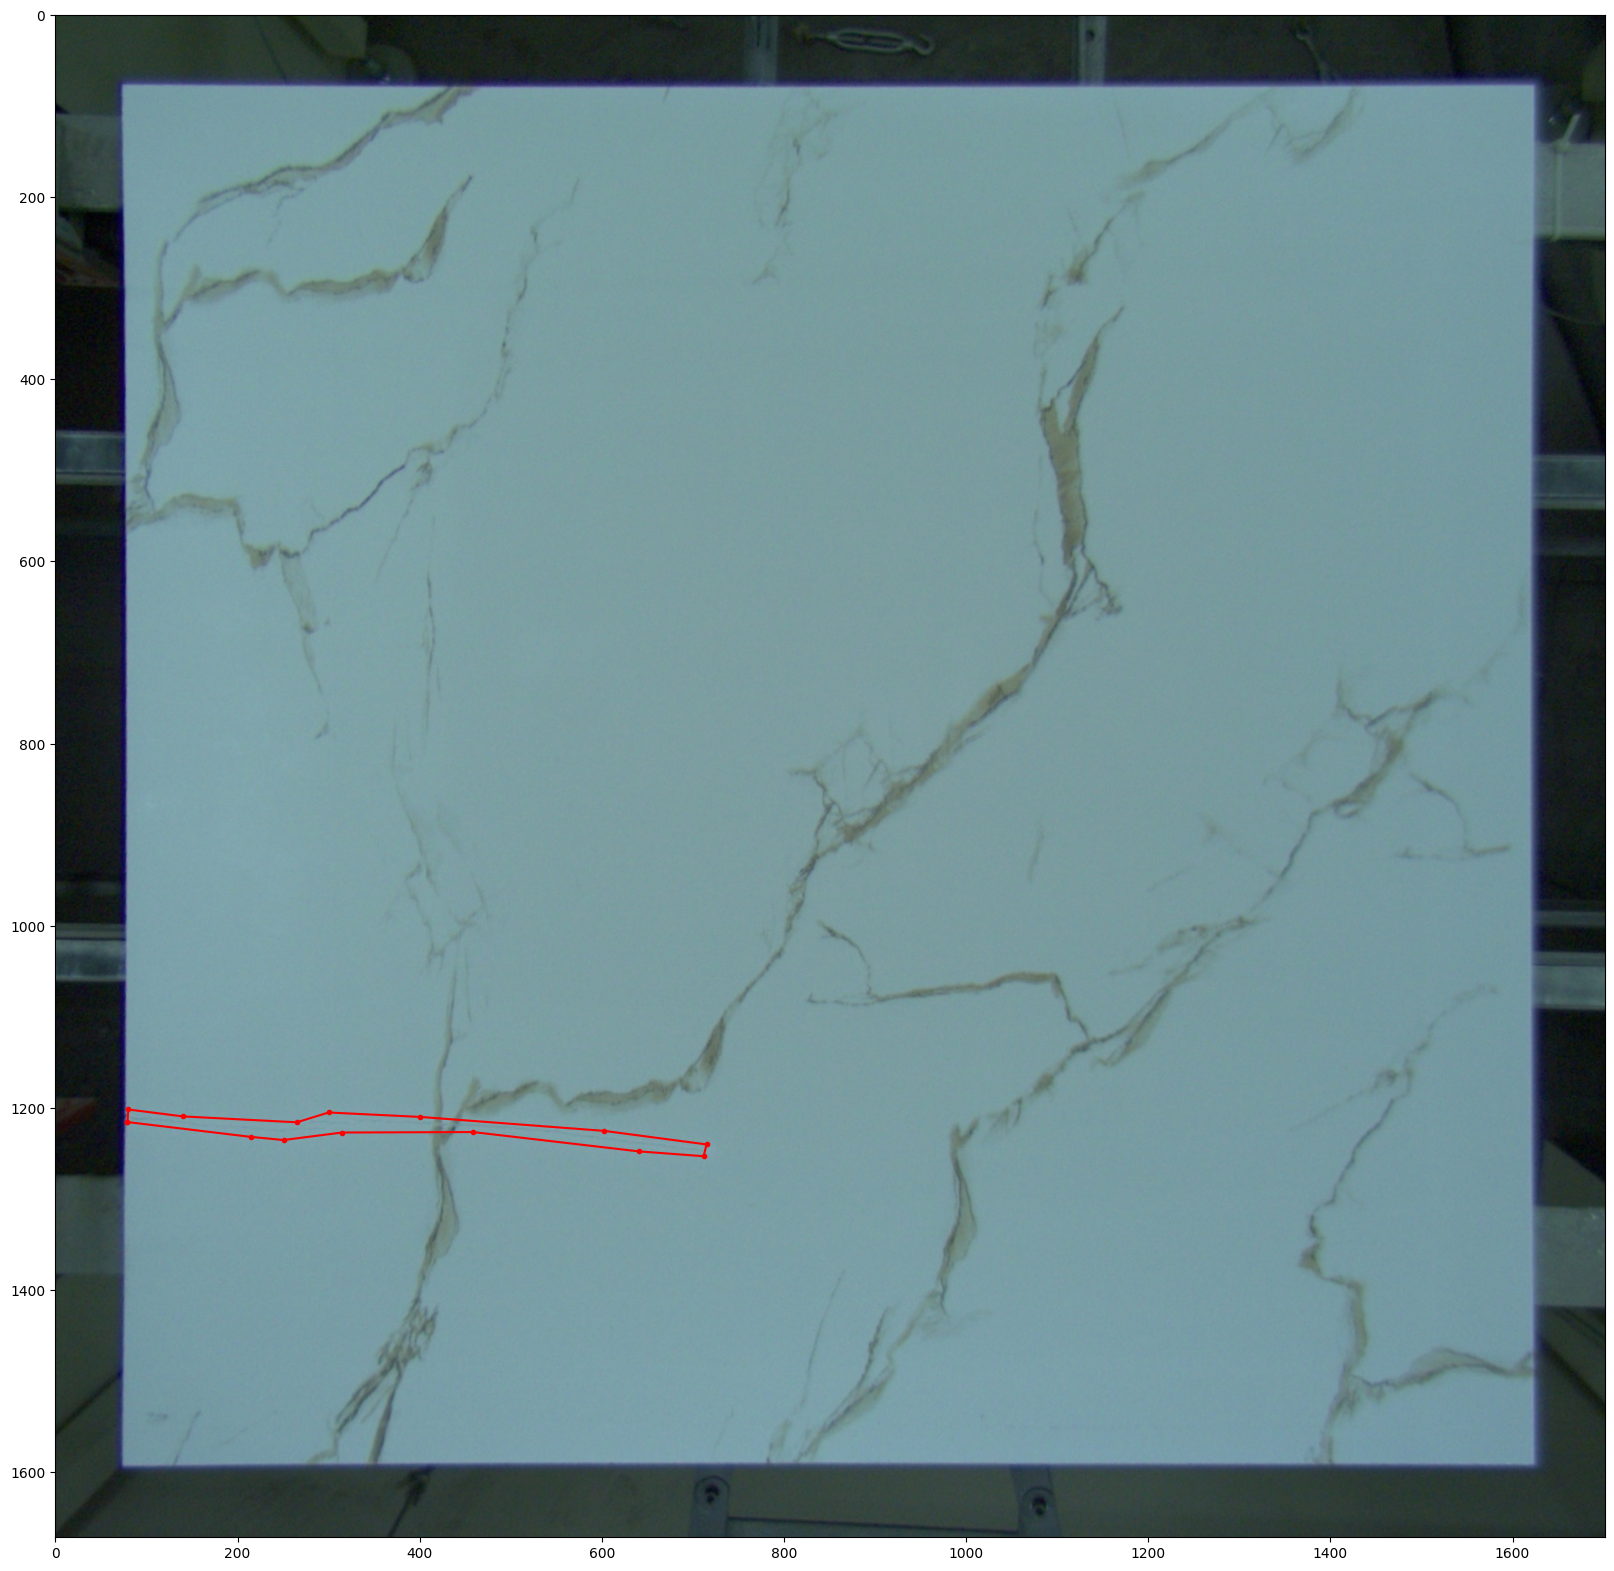

In [12]:
img = cv.imread(img_name)

f = open(json_name, encoding="utf8")
data = json.load(f)
f.close()

plt.figure(figsize=(20, 20))
plt.imshow(img[..., ::-1])

for shape in data["shapes"]: # array of json include taraks
  points = np.array(shape['points'])
  ind = list(np.arange(points.shape[0])) + [0]
  plt.plot(points[ind, 0], points[ind, 1], 'r.-')
  # plt.plot(points[-1:-3:-1, 0], points[-1:-3:-1, 1], 'r')

In [ ]:
pattern = cv.imread('/content/Patterns/' + data['pattern']) # e.g. "AYLIN.tif"

plt.figure(figsize=(20, 20))
plt.imshow(pattern[..., ::-1])

# Prepare Sequence class to load & vectorize batches of data

In [52]:
def create_binary_masks(im, shape_dicts):
    blank = np.zeros(shape=(im.shape[0], im.shape[1]), dtype=np.float32)
    for shape in shape_dicts:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(blank, [points], 255)
    return blank

In [5]:
def create_target(input_img_path):
  img = cv.imread(input_img_path)
  input_json_path = input_img_path[:-3] + 'json'
  f = open(input_json_path, encoding="utf8")
  data = json.load(f)
  f.close()

  shapes = data["shapes"]
  for shape in shapes:
    if shape["label"] == "tarak":
      points = np.array(shape["points"]) # taraks
      cv.fillPoly(img, pts=np.int32([points]), color=(0, 0, 255)) # Draw a filled polygon

  indices = np.where(img != (0, 0, 255))
  img[indices] = 0

  indices = np.where(img == (0, 0, 255))
  img[indices] = 128

  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  i1 = np.where(gray == gray[0, 0])
  i2 = np.where(gray != gray[0, 0])
  gray[i1] = 0 # not taraks
  gray[i2] = 128 # taraks

  return gray.copy()

In [ ]:
img_path = '/content/Dataset/1644360063.82364.jpg'
target = create_target(img_path)
plt.imshow(target, cmap="gray")

In [53]:
def get_corresponding_pattern(input_img_path):
  input_json_path = input_img_path[:-3] + 'json'
  f = open(input_json_path, encoding="utf8")
  data = json.load(f)
  f.close()
  pattern = cv.imread('/content/Patterns/' + data['pattern'])

  return pattern.copy()

def find_rotation_degree(good_points, kp_1, kp_2):
  # kp_1[i].pt -> mokhtasat in tile image
  # kp_2[i].pt -> mokhtasat in pattern
  # good_points[i].queryIdx -> keypoint in tile
  # good_points[i].trainIdx -> keypoint in pattern

  degrees = {'0' : 0, '90': 0, '180' : 0, '270' : 0} # all degrees can be rotated
  for good_point in good_points:
    key1_index = good_point.queryIdx
    key2_index = good_point.trainIdx

    x_1, y_1 = kp_1[key1_index].pt # 0 to 1600
    x_2, y_2 = kp_2[key2_index].pt # 0 to 5000
    # print(f"({x_1}, {y_1}) -> ({x_2}, {y_2})")

    # 800,2500 ?
    # ==============================
    if x_1 < 800 and y_1 < 800: # left top
      if x_2 < 800 and y_2 < 800:
        degrees['0'] += 1
      elif x_2 < 800 and y_2 > 800:
        degrees['90'] += 1
      elif x_2 > 800 and y_2 > 800:
        degrees['180'] += 1
      elif x_2 > 800 and y_2 < 800:
        degrees['270'] += 1
    # ==============================
    elif x_1 < 800 and y_1 > 800: # left bottom
      if x_2 < 800 and y_2 < 800:
        degrees['270'] += 1
      elif x_2 < 800 and y_2 > 800:
        degrees['0'] += 1
      elif x_2 > 800 and y_2 > 800:
        degrees['90'] += 1
      elif x_2 > 800 and y_2 < 800:
        degrees['180'] += 1
    # ===============================
    elif x_1 > 800 and y_1 > 800: # right top
      if x_2 < 800 and y_2 < 800:
        degrees['180'] += 1
      elif x_2 < 800 and y_2 > 800:
        degrees['270'] += 1
      elif x_2 > 800 and y_2 > 800:
        degrees['0'] += 1
      elif x_2 > 800 and y_2 < 800:
        degrees['90'] += 1
    # ==============================
    elif x_1 > 800 and y_1 < 800: # right bottom
      if x_2 < 800 and y_2 < 800:
        degrees['90'] += 1
      elif x_2 < 800 and y_2 > 800:
        degrees['180'] += 1
      elif x_2 > 800 and y_2 > 800:
        degrees['270'] += 1
      elif x_2 > 800 and y_2 < 800:
        degrees['0'] += 1
  result = None
  # print(degrees)
  m = 0
  for k in degrees.keys(): # finding the most repeated degree
    if degrees[k] > m:
      m = degrees[k]
      result = k
  return result

# https://pysource.com/2018/07/20/find-similarities-between-two-images-with-opencv-and-python/
def find_keypoints(img1, img2):
  original = img1 # queryImage
  image_to_compare = img2 # trainImage
  height, width, c = original.shape

  sift = cv.xfeatures2d.SIFT_create()
  kp_1, desc_1 = sift.detectAndCompute(original, None)
  kp_2, desc_2 = sift.detectAndCompute(image_to_compare, None)

  index_params = dict(algorithm=0, trees=5)
  search_params = dict()
  flann = cv.FlannBasedMatcher(index_params, search_params)

  matches = flann.knnMatch(desc_1, desc_2, k=2)

  good_points = []
  ratio = 0.7
  for m, n in matches:
      if m.distance < ratio*n.distance:
          good_points.append(m)

  no_of_matches = len(good_points)
  # result = cv.drawMatches(original, kp_1, image_to_compare, kp_2, good_points, None)

  deg = find_rotation_degree(good_points, kp_1, kp_2)
  return deg

def rotate_image(img, deg):
  if deg == '90':
    return cv.rotate(img, cv.ROTATE_90_CLOCKWISE)

  elif deg == '180':
    return cv.rotate(img, cv.ROTATE_180)

  elif deg == '270':
    return cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE)

  else: # deg == '0'
    return img

def subtract_with_morpholgy(image, pattern):
  gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY )
  binary_image = cv.adaptiveThreshold(gray_image,100,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,21,5)
  # convert to binary image (background is white, foreground is black)

  kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(7,7))
  kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))


  gray_pattern = cv.cvtColor(pattern, cv.COLOR_BGR2GRAY )
  binary_pattern = cv.adaptiveThreshold(gray_pattern,100,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,21,5)

  # growing the pattern
  eroded = cv.erode(gray_pattern,kernel,iterations=5)
  eroded_2 = cv.erode(eroded,kernel2,iterations=3)
  dilated = cv.dilate(eroded_2,kernel)
  opened = cv.morphologyEx(dilated, cv.MORPH_OPEN, kernel2,iterations=2) # removing the white pixels inside the pattern(black pixels)

  res = cv.subtract(opened, binary_image) # https://www.geeksforgeeks.org/how-to-subtract-two-images-using-python-opencv/ # https://docs.opencv.org/3.4/dd/d4d/tutorial_js_image_arithmetics.html
  # res = cv.resize(temp, dsize=(0,0), fx=224/1516, fy=224/1516)

  res = cv.cvtColor(res, cv.COLOR_GRAY2BGR)

  return res


from skimage.exposure import match_histograms

def subtract_pattern_from_image(img, pattern):
    """
        preprocessing and subtracting patten from image
    """

    # histogram matching on pattern
    # change the pattern to match the histogram of the image
    reference = img
    source = pattern
    matched_pattern = match_histograms(source, reference, multichannel=True)

    # removing rotation
    rotate_degree = find_keypoints(img, matched_pattern)
    rotated_matched_pattern = rotate_image(matched_pattern, rotate_degree) # also can use original pattern size 5000*5000 taher than resied 1600*1600

    # subtracting pattern from image
    subtracted_image = subtract_with_morpholgy(img, rotated_matched_pattern)

    return subtracted_image


In [32]:
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            if y + windowSize[1] < image.shape[0] and x + windowSize[0] < image.shape[1]:
                yield [[x, y],[x + windowSize[0], y + windowSize[1]]]

In [55]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import os

class Tiles(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        # x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="uint8") # (100, 1600, 1600, 3)
        x1 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="uint8") # (100, 1600, 1600, 3)
        x2 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="uint8") # (100, 1600, 1600, 3)
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32") # (100, 1600, 1600, 1)
        pad = 70
        for j, path in enumerate(batch_input_img_paths):
            # input img
            img = load_img(path)
            img = np.array(img)
            img = img[pad:-pad, pad:-pad] # crop the paddings
            img = cv.resize(img, self.img_size, interpolation=cv.INTER_AREA) # resize
            x1[j] = img # before adding preprocess

            # pattern img
            pattern = get_corresponding_pattern(path)
            pattern = np.array(pattern)
            pattern = cv.resize(pattern, self.img_size, interpolation=cv.INTER_AREA)
            matched_pattern = match_histograms(pattern, img, multichannel=True)
            # removing rotation
            rotate_degree = find_keypoints(img, matched_pattern)
            rotated_matched_pattern = rotate_image(matched_pattern, rotate_degree)
            x2[j] = rotated_matched_pattern

            # subtracting pattern from image
            # x[j] = subtract_pattern_from_image(img, pattern) # before adding preprocess

            # target img
            target_img = create_target(path) # our defined function
            target_img = target_img[pad:-pad, pad:-pad].copy()
            target_img = cv.resize(target_img, self.img_size, interpolation=cv.INTER_AREA)
            target_img = target_img.astype(np.float32)
            indices = np.where(target_img != 0)
            target_img[indices] = 1 # tarak (127 -> 1)
            y[j] = np.expand_dims(target_img, 2) # Expand the shape of an array. 1 -> [1] [ (1600,1600, ) -> (1600,1600,1) ]

        # return x, y
        return [x1, x2], y

# Prepare U-Net Xception-style model

In [34]:
# https://www.kaggle.com/code/meaninglesslives/unet-xception-keras-for-pneumothorax-segmentation/notebook
# https://www.researchgate.net/figure/U-Net-architecture-X-ception-style_fig4_364690133
# https://github.com/cnzakimuena/U-Net
# https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/
num_classes = 2 # tarak, not tarak
batch_size = 2
img_size = (1600, 1600)

In [65]:
import math
import glob
from skimage import exposure
from skimage.exposure import match_histograms
from skimage import data
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
import random
import keras.backend as K
from keras.utils.vis_utils import plot_model

def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((1600, 1600, 3))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(8, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(256, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(512, (5, 5), activation="relu")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(1000, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((1600, 1600, 3))
input_2 = layers.Input((1600, 1600, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [67]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

def f1(y_true, y_pred):
  def recall(y_true, y_pred):
      """Recall metric.

      Only computes a batch-wise average of recall.

      Computes the recall, a metric for multi-label classification of
      how many relevant items are selected.
      """
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall

  def precision(y_true, y_pred):
      """Precision metric.

      Only computes a batch-wise average of precision.

      Computes the precision, a metric for multi-label classification of
      how many selected items are relevant.
      """
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))


epochs = 10
batch_size = 2
margin = 1
siamese.compile(loss=loss(margin=margin), optimizer="adam", metrics=["accuracy", f1])
siamese.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 1600, 1600,  0           []                               
                                 3)]                                                              
                                                                                                  
 input_29 (InputLayer)          [(None, 1600, 1600,  0           []                               
                                 3)]                                                              
                                                                                                  
 model_16 (Functional)          (None, 1000)         6427324     ['input_28[0][0]',               
                                                                  'input_29[0][0]']        

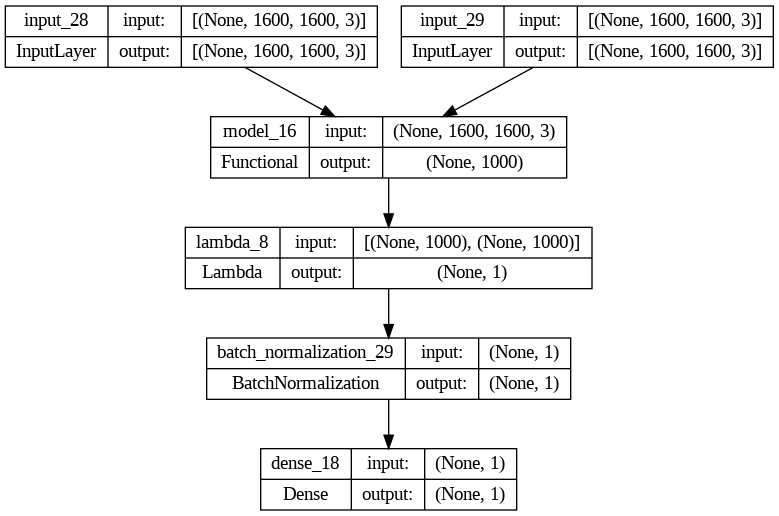

In [68]:
plot_model(siamese, show_shapes=True, show_layer_names=True)


In [ ]:
# # Free up RAM in case the model definition cells were run multiple times
# keras.backend.clear_session()

# # Build model
# model = get_model(img_size, num_classes)
# model.summary()
# keras.utils.plot_model(model)

# Read Prepared And Augmented Data Again

In [49]:
import os

input_dir = "/content/Dataset"

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if not fname.endswith(".json")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path in input_img_paths[-15:]:
    print(input_path, "|", input_path[:-3] + 'json')

Number of samples: 308
/content/Dataset/1644880490.5008993.bmp | /content/Dataset/1644880490.5008993.json
/content/Dataset/1644888240.3566377.bmp | /content/Dataset/1644888240.3566377.json
/content/Dataset/1644888256.0602736.bmp | /content/Dataset/1644888256.0602736.json
/content/Dataset/1645634834.280746.png | /content/Dataset/1645634834.280746.json
/content/Dataset/1645635002.2771971.png | /content/Dataset/1645635002.2771971.json
/content/Dataset/1645635060.518038.png | /content/Dataset/1645635060.518038.json
/content/Dataset/1645635105.105883.png | /content/Dataset/1645635105.105883.json
/content/Dataset/1645635195.07319.png | /content/Dataset/1645635195.07319.json
/content/Dataset/1645635304.7972324.png | /content/Dataset/1645635304.7972324.json
/content/Dataset/1645635403.8522236.png | /content/Dataset/1645635403.8522236.json
/content/Dataset/1645635488.3734396.png | /content/Dataset/1645635488.3734396.json
/content/Dataset/1645635557.7693658.png | /content/Dataset/1645635557.7693

# Set aside a validation split

In [63]:
import random

# Split our img paths into a training and a validation set
val_samples = 50
train_input_img_paths = input_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
# random.Random(0).shuffle(train_input_img_paths)
# random.Random(0).shuffle(val_input_img_paths)

# Instantiate data Sequences for each split
train_gen = Tiles(batch_size, img_size, train_input_img_paths) #  """Helper to iterate over the data (as Numpy arrays)."""
val_gen = Tiles(batch_size, img_size, val_input_img_paths) #  """Helper to iterate over the data (as Numpy arrays)."""

## See Tile & Pattern & Mask

In [ ]:
plt.figure(figsize=(30, 30))
plt.subplot(2, 1, 1)
imgs, targets = train_gen[7]
plt.imshow(imgs[0]) # imgs[1]

plt.subplot(2, 1, 2)
plt.imshow(targets[0], cmap="gray") # targets[1]

In [ ]:
import tensorflow as tf
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=0.01):
  # ref: https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html#6
  # (batch_size, img1, img2, num_class)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred) # DC ≥ IoU

  return (numerator + smooth) / (denominator + smooth)

def dice_bce_loss(y_true, y_pred):
    """combine DICE and BCE"""
    # ref: https://www.kaggle.com/code/kmader/u-net-with-dice-and-augmentation/notebook
    dice_loss =  1 - dice_coef(y_true, y_pred)
    return 0.01 * binary_crossentropy(y_true, y_pred) + dice_loss

# Train the model

In [69]:
# save best weights
# ref: https://towardsdatascience.com/keras-callbacks-and-how-to-save-your-model-from-overtraining-244fc1de8608
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

history = siamese.fit(
    train_gen,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_gen,
    # shuffle=True,
    # optimizer=Adam(1e-4, decay=1e-6), loss=dice_bce_loss
    callbacks=[checkpoint]
)

<ipython-input-55-287862322ec6>:38: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched_pattern = match_histograms(pattern, img, multichannel=True)


Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
# save latest weights
model.save_weights('unet.h5')

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('dice_bce_loss')
plt.savefig('model_training_history')
plt.show()

# Visualize predictions


In [ ]:
# load best weights
keras.backend.clear_session()
filepath = "my_best_model.epoch05-loss0.72.hdf5"
model = keras.models.load_model(filepath, custom_objects={"dice_bce_loss": dice_bce_loss, "dice_coef": dice_coef})

In [ ]:
from PIL import ImageOps

# Generate predictions for all images in the validation set
val_gen = Tiles(batch_size, img_size, val_input_img_paths) # 50 images (25 batches)
val_preds = model.predict(val_gen)

25/25 [==============================] - 33s 1s/step


In [ ]:
from IPython.display import Image, display

def get_visualization(i, img):
    """Quick utility to display a model's prediction."""
    probability = 1e-20
    predict = img.copy()
    mask = val_preds[i]
    mask = tf.math.sigmoid(mask)
    mask = np.array(mask)

    indices = np.where(mask >= probability)
    mask[indices] = 128

    indices = indices[0], indices[1]
    predict[indices] = (255, 0, 0)

    return mask, predict

# Display results for validation image #i
i = 0
batch = i // batch_size
j = i % batch_size
imgs, targets = val_gen[batch]

# Display input image
plt.figure(figsize=(30, 30))
plt.subplot(4, 1, 1)
plt.imshow(imgs[j])

# Display ground-truth target mask
plt.subplot(4, 1, 2)
plt.imshow(targets[j], cmap="gray")

# Display mask predicted by our model
plt.subplot(4, 1, 3)
mask, prediction = get_visualization(i, imgs[j])
plt.imshow(mask, cmap="gray")

plt.subplot(4, 1, 4)
plt.imshow(prediction)

In [ ]:
# define predict function

# define predict function
def my_get_visualization(img, mask):
    """Quick utility to display a model's prediction."""
    probability = 1e-20
    predict = img.copy()
    mask = tf.math.sigmoid(mask)
    mask = np.array(mask)

    indices = np.where(mask >= probability)
    mask[indices] = 128

    indices = indices[0], indices[1]
    predict[indices] = (255, 0, 0)

    return mask, predict


def predict_func(image, pattern):
    '''
    Receive the corresponding image and design and return the coordinates of the cracks inside it
    '''

    # load best weights
    keras.backend.clear_session()
    filepath = "my_best_model.epoch05-loss0.72.hdf5"
    model = keras.models.load_model(filepath, custom_objects={"dice_bce_loss": dice_bce_loss, "dice_coef": dice_coef})

    # load image
    img = Image.open(image)
    img = img.convert('RGB')
    img = np.array(img)
    img = img / 255.0
    img = img.astype(np.float32)

    # # load pattern
    # pattern = Image.open(pattern)
    # pattern = pattern.convert('RGB')
    # pattern = np.array(pattern)
    # pattern = pattern / 255.0
    # pattern = pattern.astype(np.float32)

    # predict
    # img = np.expand_dims(img, axis=0)
    # pattern = np.expand_dims(pattern, axis=0)
    # img = np.concatenate((img, pattern), axis=0)
    # img = np.expand_dims(img, axis=0)
    mask = model.predict(img)

    # method 1
    # mask, prediction = my_get_visualization(img[0, :, :, :], mask[0, :, :, :])
    # mask = np.where(mask >= 0.5, 1, 0)
    # mask = mask.astype(np.uint8)

    # method 2
    mask = tf.math.sigmoid(mask)
    mask = np.array(mask)
    mask = mask[0, :, :, 0]
    mask = np.where(mask >= 0.5, 1, 0)
    mask = mask.astype(np.uint8)

    # get coordinates
    contours, hierarchy = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    coordinates = []
    for i in range(len(contours)):
        x, y, w, h = cv.boundingRect(contours[i])
        coordinates.append([x, y, x+w, y+h])

    return coordinates
